In [391]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [392]:
# Import dataset
df = pd.read_csv('../data/features-total-80c4772.csv', index_col='revision_id')
tag_df = pd.read_csv('../data/tag.csv', index_col='id')
df.head()

,isContributorAnonymous,isBot,timeOfDay,dayOfWeek,isMinorEdit,hasPreviousSameContributor,timeSinceLastArticleEdit,timeSinceLastArticleEditBySameContributor,timeSinceFirstArticleEditBySameContributor,revertCount,...,sizeChange,sizeRatio,LZWCompressionRate,KLDOfCharDistribution,commentLength,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,tag_id
revision_id,,,,,,,,,,,,,,,,,,,,,
228189784,0.0,0.0,13.0,7.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,...,11909.0,11910.000000,0.513889,1024.000000,34.0,0.0,0.0,0.0,0.0,12
730449352,0.0,0.0,2.0,2.0,0.0,1.0,25.0,25.0,198701.0,0.0,...,504.0,0.003832,0.308994,4.126739,14.0,0.0,0.0,0.0,0.0,12
216224416,0.0,0.0,17.0,6.0,1.0,0.0,7837.0,-1.0,-1.0,0.0,...,78.0,0.003622,0.434896,85.525822,67.0,0.0,0.0,2.0,0.0,12
539338621,0.0,1.0,1.0,4.0,1.0,0.0,2108.0,-1.0,-1.0,0.0,...,-14.0,-0.000196,0.353894,1.286642,152.0,0.0,0.0,0.0,0.0,12
746191686,1.0,0.0,20.0,2.0,0.0,0.0,4077.0,-1.0,-1.0,0.0,...,0.0,0.000048,0.428264,342.595182,10.0,0.0,0.0,0.0,0.0,12


In [393]:
# Evaluation utils
def plot_confusion_matrix(y_test, y_pred, no_vandalism_count, vandalism_count):
    cfn_matrix = confusion_matrix(y_test, y_pred)
    cfn_norm_matrix = np.array([[1.0/no_vandalism_count, 1.0/no_vandalism_count], [1.0/vandalism_count, 1.0/vandalism_count]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix, annot=True, fmt="d", linewidths=0.5, ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix, linewidths=0.5, annot=True, ax=ax)
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('Classification Report')
    classes = ['No Vandalism', 'Vandalism']
    print(classification_report(y_test, y_pred, target_names=classes))
    
def plot_scores(scores):
    print('Cross validation scores')
    scores = list(scores.items())[2:]

    for score in scores:
        plt.plot(score[1], label=score[0])
        plt.legend()
    plt.show()

In [394]:
# Preprocessing utils
class VandalismEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, tag_ids):
        self.tag_ids = tag_ids
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['is_vandalism'] = X.tag_id.isin(self.tag_ids)
        X = X.drop(['tag_id'], axis=1)
        return X

    def fit_transform(self, X, y):
        return self.transform(X)
    
class RevisionGrouper(BaseEstimator, TransformerMixin):        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.groupby(X.index).apply(self._vandalism_revision_or_first)
        return X

    def fit_transform(self, X, y=None):
        return self.transform(X)
    
    def _vandalism_revision_or_first(self, group):
        vandalism_revisions = group.loc[group['is_vandalism'] == True]
        return vandalism_revisions.iloc[0] if len(vandalism_revisions) > 0 else group.iloc[0]

In [395]:
# Preprocess data
preprocess_pipeline = Pipeline([
        ('vandalism_encoder', VandalismEncoder([1, 2, 3, 4, 5])),
        ('revision_grouper', RevisionGrouper())
    ])

processed_df = preprocess_pipeline.transform(df)

In [396]:
# X, y split
X = processed_df.drop(['is_vandalism'], axis=1)
y = processed_df['is_vandalism']

In [397]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X train', X_train.shape)
print('y train', y_train.shape)
print('X test', X_test.shape)
print('y test', y_test.shape)

X train (3723, 63)
y train (3723,)
X test (1242, 63)
y test (1242,)


In [ ]:
# Grid search model params
parameters = [{
    'n_estimators': [250, 500, 750],
    'class_weight': ['balanced', {0:1,1:1}]
}]

grid_search = GridSearchCV(RandomForestClassifier(),
                           parameters, 
                           scoring=['f1', 'precision', 'recall', 'roc_auc'],
                           refit='f1',
                           cv=10)
grid_search.fit(X_train, y_train)

params = grid_search.best_params_
print('Best params', grid_search.best_params_)
print('Best score', grid_search.best_score_)

In [398]:
# Train scores & predictions
clf = RandomForestClassifier(n_estimators=params['n_estimators'], class_weight=params['class_weight'], n_jobs=-1)
train_scores = cross_validate(clf, X_train, y_train,
                        scoring=['f1', 'precision', 'recall', 'roc_auc', 'accuracy'],
                        cv=10, n_jobs=-1, return_train_score=False)

y_train_predict = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1, method='predict')
y_train_predict_proba = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1, method='predict_proba')

Cross validation scores


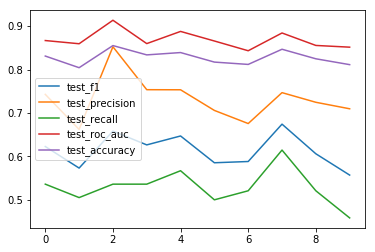

In [399]:
plot_scores(train_scores)

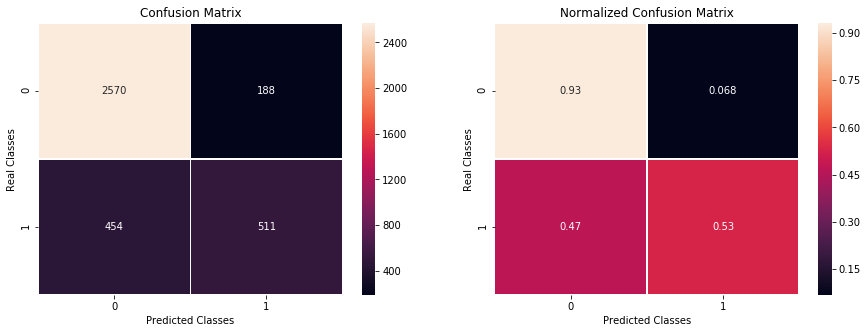

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.85      0.93      0.89      2758
   Vandalism       0.73      0.53      0.61       965

 avg / total       0.82      0.83      0.82      3723



In [400]:
train_vandalism_count = y_train.value_counts()[True]
train_no_vandalism_count = y_train.value_counts()[False]
plot_confusion_matrix(y_train, y_train_predict, train_no_vandalism_count, train_vandalism_count)

KeyboardInterrupt: 

0.6118140512653183